In [2]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter

In [3]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats

axis_sz= 14
tick_sz= 14

In [4]:
def ox_po4_convert(dataset, **kwargs):
    if max(dataset.cluster_d['oxygen'])<300:
        ox_convert = lambda x: x*44.661
        dataset.cluster_d['oxygen'] = ox_convert(dataset.cluster_d['oxygen'])

    OP = {'SAtl':182, 'NAtl':173, 'SO_CDW':182, 'SO_shelf': 182}
    po4_convert = lambda x,y: x + y/175
    if 'corrected_OP' in kwargs:
        po4_star_c = []
        po4_convert_corr = lambda x,y,z: x + y/OP[z]
        for ik in range(len(dataset.cluster_d['latitude'])):
            if dataset.cluster_d['labels'][ik] in OP:
                po4_star_c.append(po4_convert_corr(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik], dataset.cluster_d['labels'][ik]))
            else:
                po4_star_c.append(po4_convert(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik]))
        dataset.cluster_d['po4_star_c'] = np.asarray(po4_star_c, dtype=float)
    dataset.cluster_d['po4_star'] = po4_convert(dataset.cluster_d['phosphate'], dataset.cluster_d['oxygen'])
    return dataset

In [5]:
def label_lat_ranges(dataset):
    lat_range_d = {(90,-10):'NAtl', (-10, -90):'SAtl', (-50, -70):'SO_CDW', (-70,-90):'SO_shelf'}
    labels = []
    
    for lat in dataset.cluster_d['latitude']:
        for key in lat_range_d:
            if lat<=key[0] and lat>key[1]:
                labels.append(lat_range_d[key])
    dataset.cluster_d['labels']= labels
    
    return dataset

## Background

### Watermass fraction
When water in the high latiude Atlantic sinks to the deep ocean in the north as North Atlantic Deep Water or in the south as Antarctic Bottom Water, heat and CO<sub>2</sub> are transported from the atmosphere into the ocean interior.  Variation in the ratio of northern sourced to southern sourced water affect the efficacy of the ocean as a sink, so the relative contributions of these two watermasses is a topic of active research for climate scientists and oceanographers.  

### Observed Tracers
As processes occur in the ocean, the concentration of chemical constituents change. For example, evaporation results in increased salinity, and cell building by organisms takes up dissolved phosphate from the surrounding water, driving down the phosphate concentration.  Salinity, and phosphate, in addition to nitrate, oxygen, and temperature (though a physical parameter of the ocean rather than a chemical), among many others, are referred to as "tracers" because when plotted out, they help oceanographers "trace" the paths of water and the processes occurring in the ocean. When a tracer concentration is  determined at the ocean surface at water formation and is distributed strictly by ocean circulation and mixing (viz. is unaffected by any additional biogeochemical processes), the tracers is considered “conservative.” Salinity, as well as certain CFCs present in the atmosphere that dissolve in surface water, are examples of conservative tracers. 

### PO<sub>4</sub>\*

The concentration of phosphate in the deep ocean reflects a combination of the amount of phosphate present in the water at the time of water formation, and the amount contributed by regenerated organic matter (phytoplankton that have died, sunk to some depth, and dissolved into constituent molecules).  In 1998, Broecker et al. published a paper suggesting that by correcting PO<sub>4</sub> for non-conservative contribution of PO<sub>4</sub> by decomposign organic matter, PO<sub>4</sub> could be treated as a conservative tracer, "PO<sub>4</sub>\*" and could be used to trace the relative contributions of different watermasses at a given location.

The formula they put forth was relatively simple:  
PO<sub>4</sub>\* =PO<sub>4</sub> + O<sub>2</sub>/175 -1.95  
(Broecker has noted in multiple papers he regrets introducing the constant, as it is arbitrary, so it has be ommitted here.)

where 175 is the global average moles of oxygen per molecule PO<sub>4</sub> (O<sub>2</sub>:PO<sub>4</sub>) needed to respire decaying phytoplankton.  


In [6]:
def concat(dataset1, dataset2):
    for key in dataset1.cluster_d.keys():
        dataset1.cluster_d[key] = np.concatenate((dataset1.cluster_d[key], dataset2.cluster_d[key]))
    dataset1._x = dataset1.cluster_d['longitude']
    dataset1._y = dataset1.cluster_d['latitude']     
    dataset1._d = dataset1.cluster_d['depth']                                            
    return dataset1

In [7]:
tracers_psql = ['phosphate', 'oxygen', 'nitrate', 'salinity']
tracer_string = ','.join(tracers_psql)

In [47]:
dataset_Atl = dataFetcher()
dataset_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < 0 and longitude >-70 and latitude> -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_Atl= ox_po4_convert(label_lat_ranges(dataset_Atl), corrected_OP= True)
df_Atl = pd.DataFrame(dataset_Atl.cluster_d)


In [48]:
dataset_SO = dataFetcher()
dataset_SO.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_SO= ox_po4_convert(label_lat_ranges(dataset_SO), corrected_OP= True)
df_SO = pd.DataFrame(dataset_SO.cluster_d)


In [61]:
# specifies the ocean in parts that are representative of the global ocean and exclude anamolous riverine inputs etc.
# key: ([min_lon, max_lon], [min_lat, max_lat])
ocean_parts = {'NNAtl':([-70,10],[60,90]),
               'NAtl': ([-70, -10],[60,0]),
               'SAtl': ([-70,20],[-50,0]),
               'Ind': ([20,90],[-50,10]),
               'Aus': ([90,150],[-50, -10]),
               'NPac_E': ([-180,-100],[0, 50]),
               'NPac_W': ([140, 180],[0, 50]),
               'SPac_E': ([-180, -70],[-50, 0]),
               'SPac_W': ([150, 180],[-50, 0])
                    }

In [63]:
# Global Ocean
dataset_globe = dataFetcher()
dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')

for key in ocean_parts.keys():
    ([min_lon, max_lon], [min_lat, max_lat]) = ocean_parts[key]
    dataset_new = dataFetcher()
    dataset_new.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude <{} and latitude> {} and depth >=3000'.format(tracer_string, max_lon, min_lon, max_lat, min_lat),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
    dataset_globe = concat(dataset_globe, dataset_new)

dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [65]:
df_all = pd.concat([df_Atl,df_SO, df_globe])

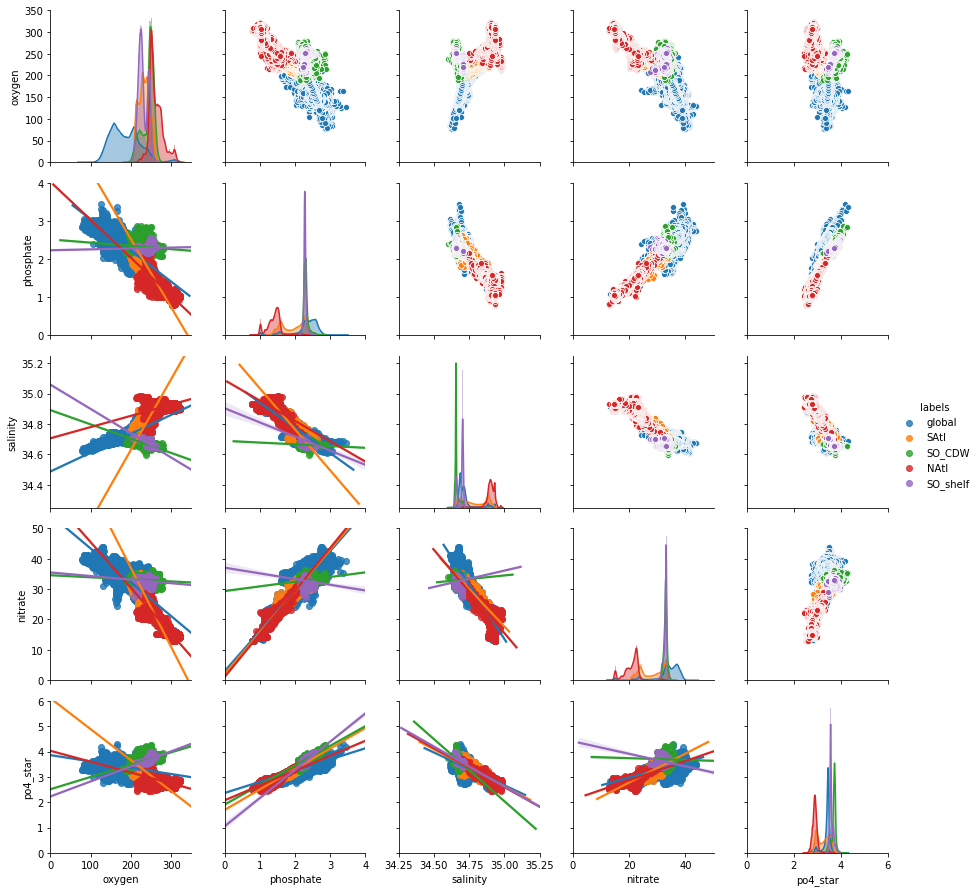

In [71]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate','po4_star', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)

g.axes[0,0].set_xlim(0,350)
g.axes[0,0].set_ylim(0,350)
g.axes[0,1].set_xlim(0,4)
g.axes[1,0].set_ylim(0,4)
g.axes[0,2].set_xlim(34.25,35.25)
g.axes[2,0].set_ylim(34.25,35.25)
g.axes[0,3].set_xlim(0,50)
g.axes[3,0].set_ylim(0,50)
g.axes[0,4].set_xlim(0,6)
g.axes[4,0].set_ylim(0,6)

g.add_legend()

So why PO<sub>4</sub>? Unlike nitrate and oxygen, the concentration of PO<sub>4</sub> is not affected by processes other than uptake by organisms and regeneration of said organisms post mortem.  (Oxygen and nitrate are both oxidation agents in the decay of organic matter, plus the the concentration of oxygen is also affected by equilibration between the surface ocean and the atmosphere.) The scatter plots above (N.B."global ocean" data has been filtered to omit areas near continents where local dynamics give rise to data that does not reflect the larger trends of the deep open ocean) suggest that PO<sub>4</sub> has the tightest relationship to salinity (a conservative tracer) and that once corrected, PO<sub>4</sub>\* plotted against salinity forms a reasonable mixing line capped by endmembers located at water formation sites (labelled SO-CDW and NAtl).

Implicit in PO<sub>4</sub>\* is the assumption that phytoplankton have roughly the same composition and therefore that one might expect the O<sub>2</sub>:PO<sub>4</sub> (oxygen consumed during decay of organic matter) to be similarly predictable. Indeed, looking at the regression lines in the phosphate-nitrate plot, the similarity of the slopes for the Atlantic and global oceans suggest that this is not an unfair simplification.  



In [225]:
# High Latitude Atlantic
dataset_high_lat_Atl = dataFetcher()
dataset_high_lat_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE (longitude < 0 and longitude >-70) and (latitude >50 or latitude <-45) and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_high_lat_Atl= ox_po4_convert(dataset_high_lat_Atl)


High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)


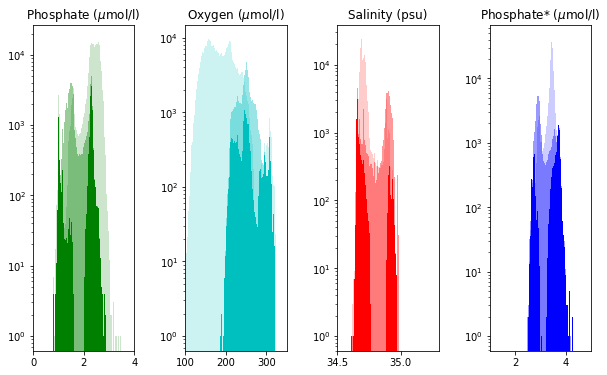

In [227]:
print('High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)')
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [0, 4], 'g'],
          'oxygen': ['Oxygen ($\mu$mol/l)', [100, 350], 'c'],
          'salinity': ['Salinity (psu)', [34.5, 35.3], 'r'],
          'po4_star': ['Phosphate* ($\mu$mol/l)', [1, 5], 'b']}

fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(1,len(tracers), width_ratios=np.ones(len(tracers)), wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    n, bins, patches = ax_out[ik].hist(dataset_globe.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .2)
    n, bins, patches = ax_out[ik].hist(dataset_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .4)
    n, bins, patches = ax_out[ik].hist(dataset_high_lat_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = 1)
    ax_out[ik].set_xlim(tracers[tracer][1])
    ax_out[ik].set_title(tracers[tracer][0])
    plt.yscale('log', nonposy='clip')

The above histograms give a clearer view of how the ranges of PO<sub>4</sub> and oxygen extend beyond the values of the high latitude Atlantic, while PO<sub>4</sub>\* and salinity do a fairly good job bounding their respective global distributions, making them appropriate for watermass fraction calculations. 

## Problem

PO$_4$\* is conceptually pleasing, but a recent paper by Rae and Broecker (2018) attempted to calculate the ratio of Southern Ocean to North Atlantic Deep Water in the Pacific based on PO$_4$\* and came up short when they compared their calculations to the numbers necessary to satisfy the salinity budget of the deep Pacific.  

## Hypothesis

While the assumption of a constant O<sub>2</sub>:PO<sub>4</sub> embedded in the PO<sub>4</sub>\* calculation is convenient, there is a body of research that suggests that there may be some regional variation in phytoplankton molecular composition and also in the O<sub>2</sub>:PO<sub>4</sub>.

I hypothesize that specifying the O<sub>2</sub>:PO<sub>4</sub> by region will improve the watermass fraction estimates generated using PO<sub>4</sub>\* and bring them more in line with those calculated based on salinity. 

## Plan
#### The dataset: World Ocean Atlas 2013
The World Ocean Atlas 2013 is an ocean data product produced by the Ocean Climate Laboratory and the National Oceanographic Data Center.  WOA fields include temperature, salinity, phosphate, nitrate, oxygen, silicic acid, among others and are reported at 1 degree resolution at 102 standard depth levels from surface to the abyssal floor (5500m). 

#### Proposed study
Borrowing ideas from the previous capstone exercise, I propose to compare fraction of southern sourced water calculated from salinity to that calculated using PO<sub>4</sub>\* at a given depth from the same ten degree section of constant latitude (longitude: 30W to 20W) using a paired t-test, for a range of latitudes. I then propose to repeat the calculation with the corrected PO<sub>4</sub>\* and plot the two sets of p-values relative to latitude for a range of depths of the deep ocean.   

Initial work at a few depths suggests that this is a reasonable approach (see below), but that the calculation is sensitive to the O<sub>2</sub>:PO<sub>4</sub> chosen for the Southern Ocean (where there is not a published value available) and the latitude dividing the South Atlantic from the North Atlantic. Fully characterizing the usefulness of this correction would require doing a gridsearch in the parameter space and evaluation of the optimal pair.   

In [36]:
line_lon = -25
min_lat, max_lat = -80, 80

tracers_psql = ['salinity', 'phosphate', 'oxygen']
tracer_string = ','.join(tracers_psql)

datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers_psql)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )
    
min_lon, max_lon = -30, -20
latitudes = [x+.5 for x in range(-70, 55)]#-50.5
depths = [x for x in range(2500, 4000, 500)]


tracers = ['salinity', 'po4_star', 'po4_star_c']
mixing_ratios = {dpth:{} for dpth in depths}

for dpth in depths:
    print(dpth)
    tracer_endmem = {}
    for trcr in tracers:
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        tracer_endmem[trcr]= {'n_char':Atl.n_char, 's_char':Atl.s_char}
    for lat in latitudes:
        mixing_ratios[dpth][lat] ={tracer:[] for tracer in tracers}
        dataset_lonslice = dataFetcher()
        dataset_lonslice.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude= {} and depth ={}'.format(tracer_string, max_lon, min_lon, lat, dpth),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
        dataset_lonslice= ox_po4_convert(label_lat_ranges(dataset_lonslice), corrected_OP= True)
        for trcr in tracers:
            for ik in range(len(dataset_lonslice.cluster_d[trcr])):
                obs = dataset_lonslice.cluster_d[trcr][ik]
                mixing_ratios[dpth][lat][trcr].append(max(min((obs-tracer_endmem[trcr]['n_char'])/(tracer_endmem[trcr]['s_char']-tracer_endmem[trcr]['n_char']), 1), 0))

            

[2500, 3000, 3500]
2500
3000
3500


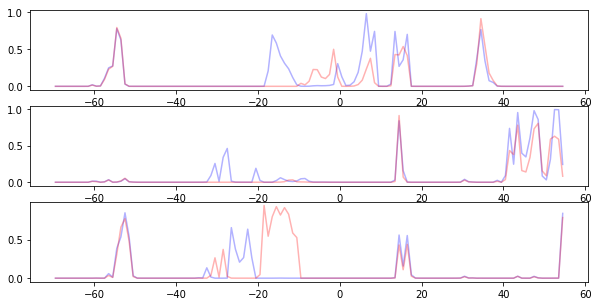

In [40]:
fig ,ax = plt.subplots(nrows=3, ncols=1, figsize = (10,5))
pval_d = {dpth: {'po4_star':[], 'po4_star_c':[]} for dpth in depths}
for ik, dpth in enumerate(depths):
    for lat in latitudes:
        tval,pval=stats.ttest_ind(mixing_ratios[dpth][lat]['salinity'], mixing_ratios[dpth][lat]['po4_star'])
        pval_d[dpth]['po4_star'].append(pval)
        tval,pval=stats.ttest_ind(mixing_ratios[dpth][lat]['salinity'], mixing_ratios[dpth][lat]['po4_star_c'])
        pval_d[dpth]['po4_star_c'].append(pval)
    ax[ik].plot(latitudes, pval_d[dpth]['po4_star'], c= 'b', alpha = .3)
    ax[ik].plot(latitudes, pval_d[dpth]['po4_star_c'], c= 'r', alpha = .3)
